In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("data/Flight_Price_Dataset_of_Bangladesh.csv")

print("Dataset loaded successfully.")
print("Shape:", df.shape)


Dataset loaded successfully.
Shape: (57000, 17)


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


## Fare Distribution 

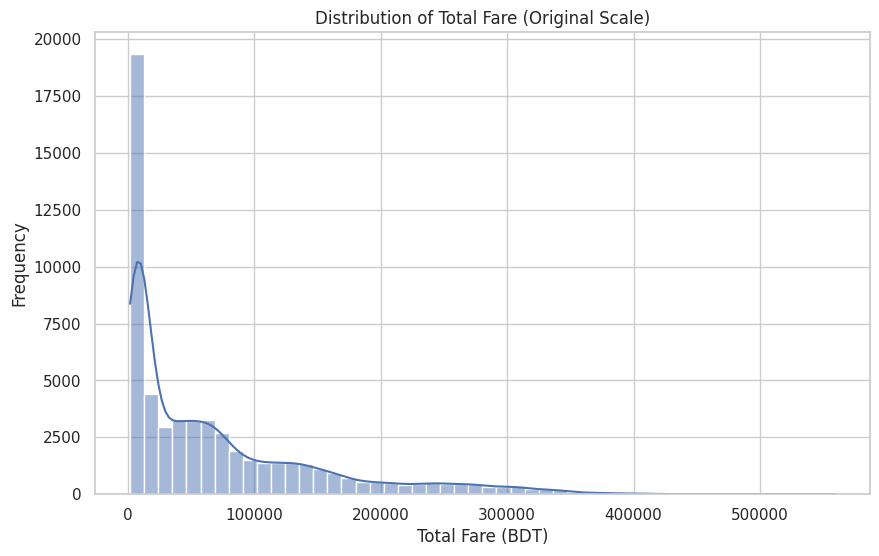

In [3]:
plt.figure()
sns.histplot(df["Total Fare (BDT)"], bins=50, kde=True)
plt.title("Distribution of Total Fare (Original Scale)")
plt.xlabel("Total Fare (BDT)")
plt.ylabel("Frequency")
plt.show()


The total fare distribution is heavily right-skewed, indicating the presence of high-price outliers. Most tickets are concentrated below 100,000 BDT, but a long right tail reflects premium or long-haul flights. This justifies applying a log transformation to stabilize variance and improve regression performance.

### Fare Distribution (Log Transformed)

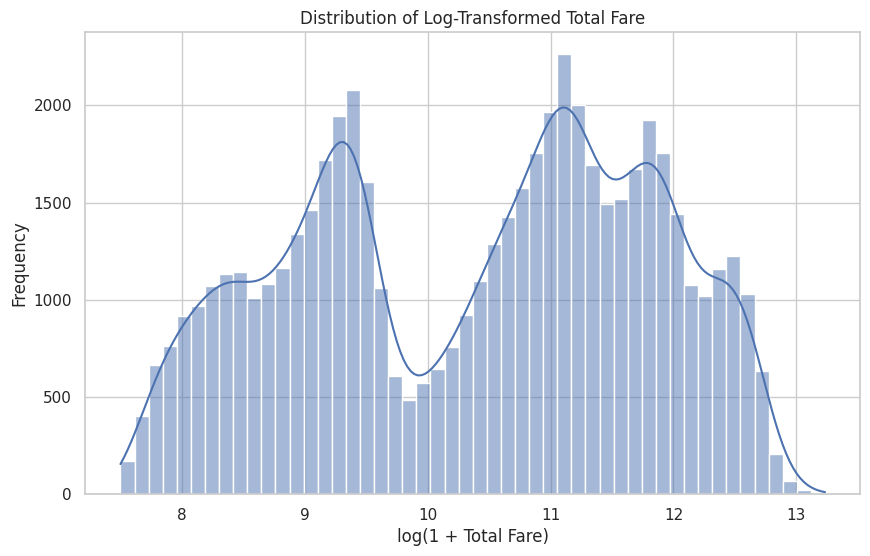

In [4]:
plt.figure()
sns.histplot(np.log1p(df["Total Fare (BDT)"]), bins=50, kde=True)
plt.title("Distribution of Log-Transformed Total Fare")
plt.xlabel("log(1 + Total Fare)")
plt.ylabel("Frequency")
plt.show()


After log transformation, the fare distribution becomes significantly more symmetric and closer to normal. This transformation improves linear model assumptions and reduces heteroscedasticity.

## Average Fare by Airline

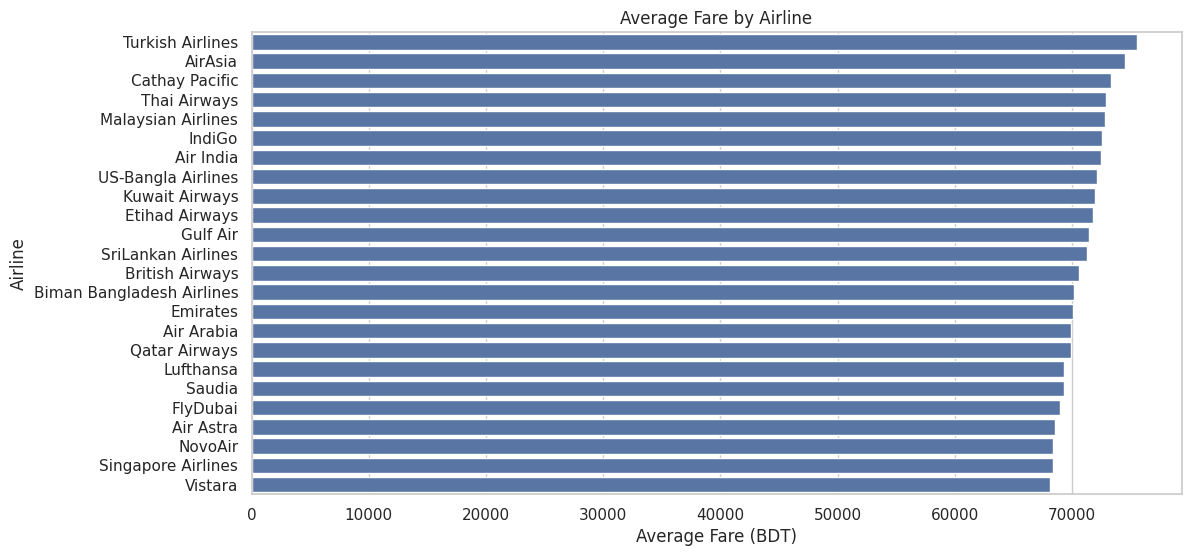

In [5]:
avg_fare_airline = (
    df.groupby("Airline")["Total Fare (BDT)"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12,6))
sns.barplot(
    x=avg_fare_airline.values,
    y=avg_fare_airline.index
)
plt.title("Average Fare by Airline")
plt.xlabel("Average Fare (BDT)")
plt.ylabel("Airline")
plt.show()


### Observation:

Turkish Airlines highest average

Vistara lowest

Spread roughly 68k–73k

 Airlines exhibit noticeable pricing differences. Premium international carriers (e.g., Turkish Airlines, Cathay Pacific) tend to charge higher fares, likely due to service level and route coverage. Budget carriers show lower averages. Airline choice is therefore a strong predictive feature.

## Fare by Season (Boxplot)

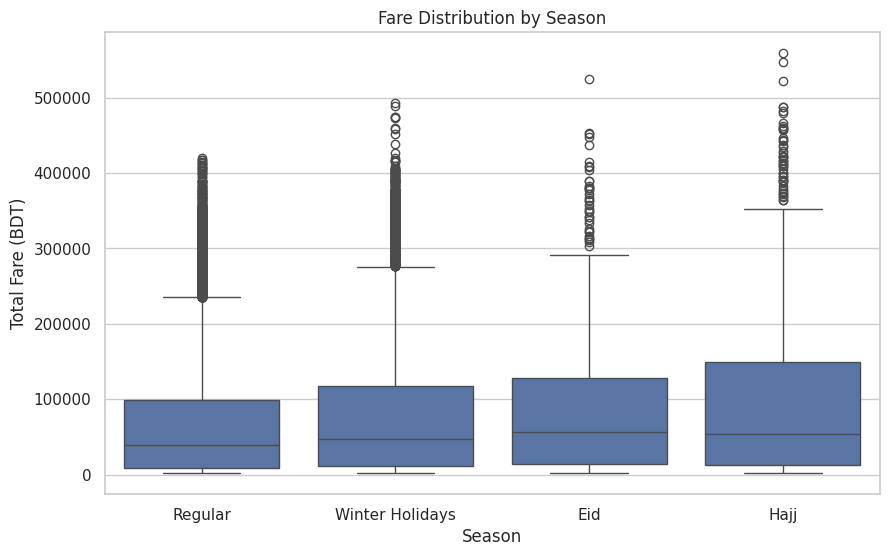

In [6]:
plt.figure()
sns.boxplot(
    x="Seasonality",
    y="Total Fare (BDT)",
    data=df
)
plt.title("Fare Distribution by Season")
plt.xlabel("Season")
plt.ylabel("Total Fare (BDT)")
plt.show()


### Observation:

Hajj → highest spread and median

Eid & Winter → elevated

Regular → lowest


Fare distributions vary substantially across seasons. Hajj and Eid seasons show significantly higher medians and larger variance, reflecting strong demand-driven price surges. This confirms seasonality as a critical pricing driver.

## Correlation Heatmap (Numerical Only)

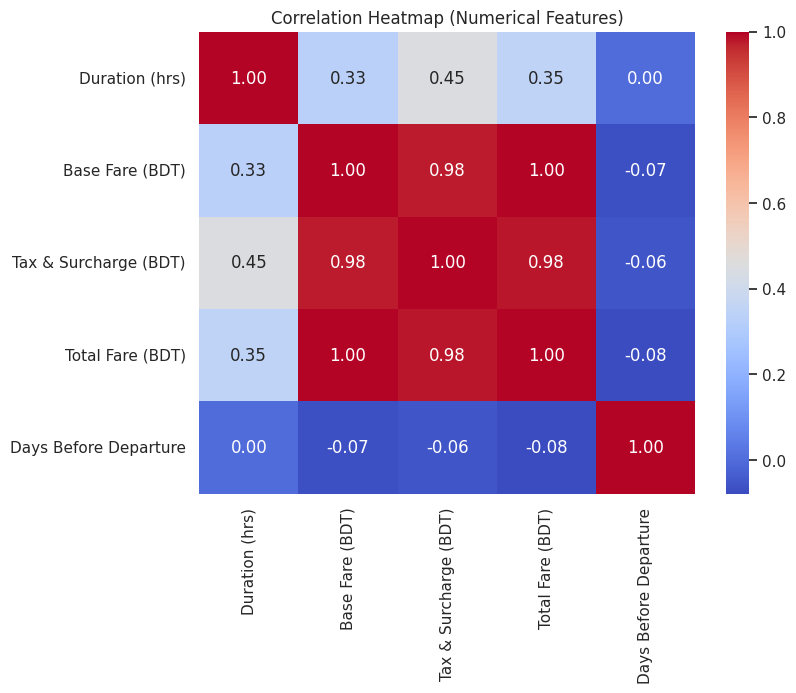

In [7]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(8,6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()


### Observation:

Base Fare & Tax highly correlated with Total Fare (~1.00)

Duration moderately correlated (0.35)

Days Before Departure slightly negative (-0.08)

Total Fare is strongly correlated with Base Fare and Tax & Surcharge, which confirms target leakage risk if included as features. Duration shows moderate positive correlation, indicating longer flights tend to cost more. Days Before Departure has weak negative correlation, suggesting early booking slightly reduces fares.

## Predicted vs Actual (Model Performance)

In [8]:
import joblib
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("data/Flight_Price_Dataset_of_Bangladesh.csv")

# Load trained model
best_model = joblib.load("models/best_model.pkl")

print("Dataset and model loaded successfully.")


Dataset and model loaded successfully.


In [9]:
from sklearn.model_selection import train_test_split

# Remove leakage columns
leakage_columns = [
    "Base Fare (BDT)",
    "Tax & Surcharge (BDT)",
    "Total Fare (BDT)"
]

y = np.log1p(df["Total Fare (BDT)"])
X = df.drop(columns=leakage_columns)

# Split exactly like training
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)



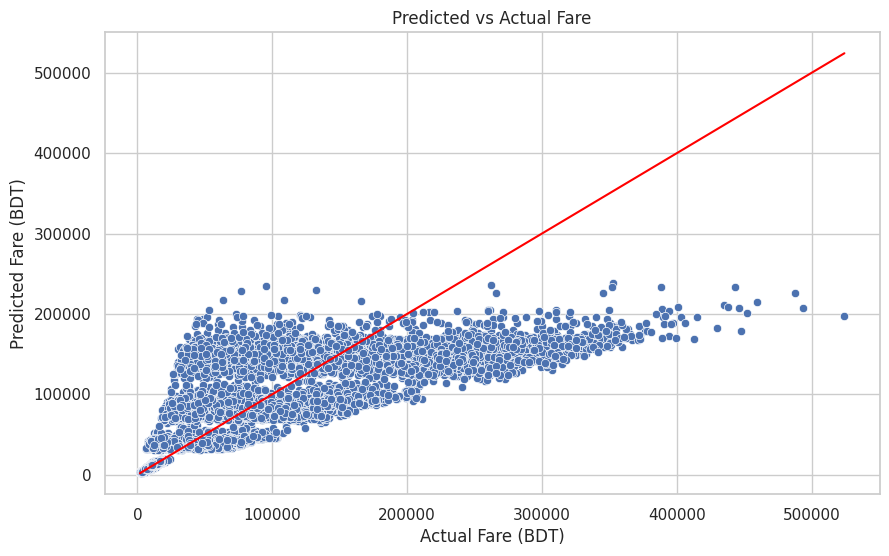

In [10]:
# Get predictions
preds_log = best_model.predict(X_test)

# Convert back to original scale
preds = np.expm1(preds_log)
actual = np.expm1(y_test)

plt.figure()
sns.scatterplot(x=actual, y=preds)
plt.plot([actual.min(), actual.max()],
         [actual.min(), actual.max()],
         color="red")
plt.title("Predicted vs Actual Fare")
plt.xlabel("Actual Fare (BDT)")
plt.ylabel("Predicted Fare (BDT)")
plt.show()


### Observation:

Looking at your plot:

Good linear alignment for mid-range prices

Underestimation for very high fares

The model performs well across mid-range fares but tends to underestimate extremely high-priced tickets. This indicates the presence of complex nonlinear pricing patterns at the upper tail, which linear models struggle to fully capture.

## Residual Plot

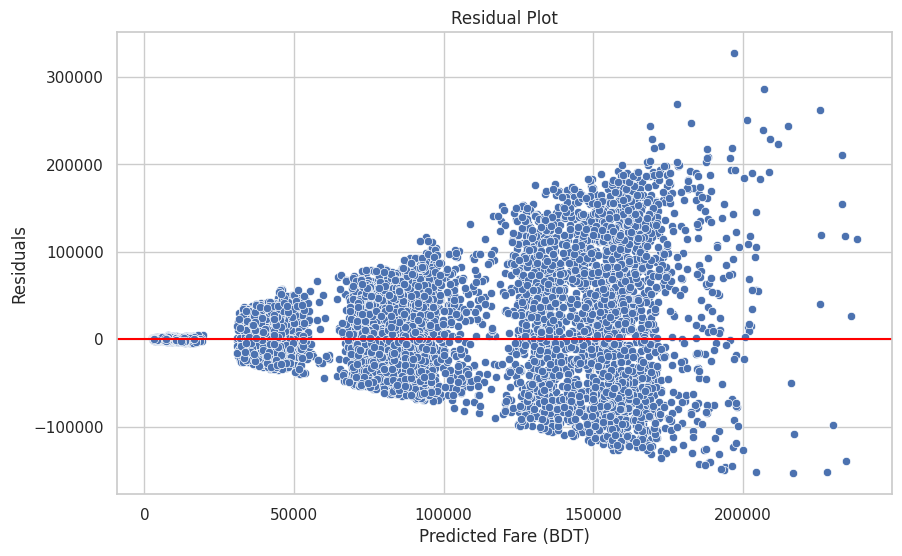

In [11]:
residuals = actual - preds

plt.figure()
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red")
plt.title("Residual Plot")
plt.xlabel("Predicted Fare (BDT)")
plt.ylabel("Residuals")
plt.show()


### Observation:
residual plot shows:

Funnel shape

Larger variance at higher predictions


Residual variance increases with predicted fare, indicating mild heteroscedasticity. Although log transformation reduced skewness, high-fare variability remains more difficult to predict accurately.

## Feature Importance (Lasso Coefficients)

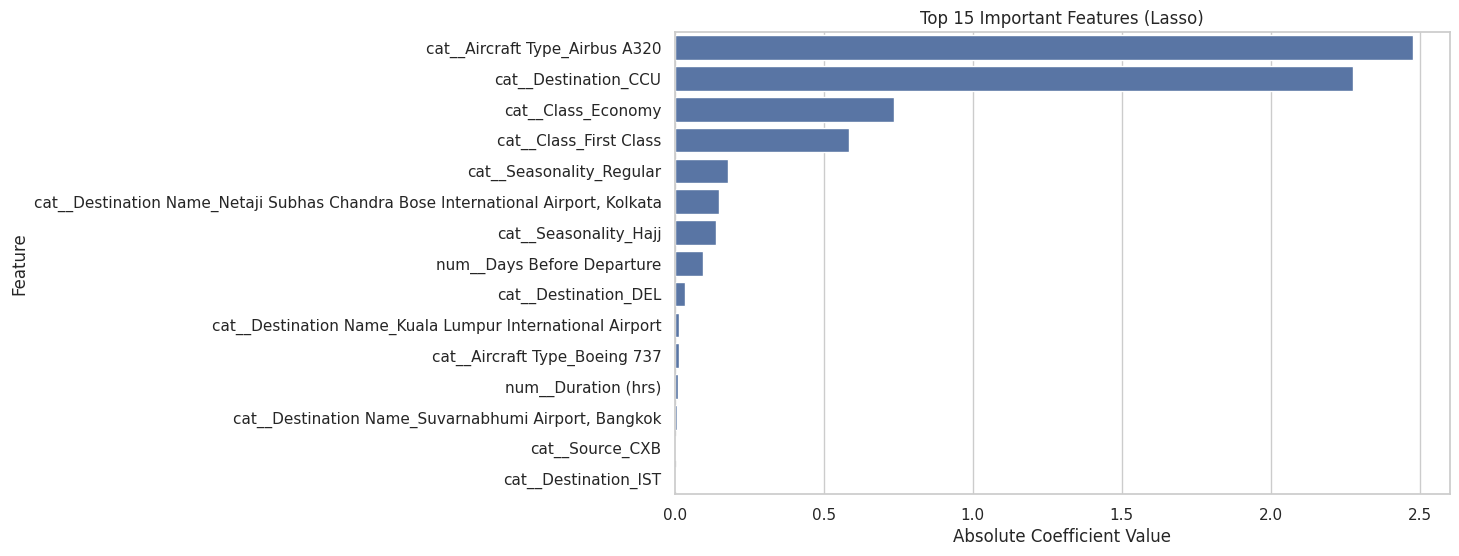

In [12]:
# Extract feature names after preprocessing
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()

coefficients = best_model.named_steps["model"].coef_

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

importance_df["Abs Coefficient"] = importance_df["Coefficient"].abs()

top_features = (
    importance_df
    .sort_values("Abs Coefficient", ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
sns.barplot(
    x="Abs Coefficient",
    y="Feature",
    data=top_features
)
plt.title("Top 15 Important Features (Lasso)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.show()


### Observation:

The most influential predictors include aircraft type, destination, travel class, and seasonality. Class-based pricing and destination demand appear to drive significant fare differences. Booking timing has smaller but measurable impact.